# Isolate Imputations

An inital approach to isolate imputations was to copy and paste from the related article on Fangraphs. This notebook serves as an analysis approach to _derive_ the imputed values based on flagging if a certain exit velo/launch angle comprises more than a given percentage of the total dataset for a bb_type.

In [1]:
from pybaseball import statcast, utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybaseball.plotting import plot_bb_profile

Since there's a bit of variance year-to-year and especially difference in 2020 with Hawkeye, grab a month from each year

In [2]:
# Grab 1 month per year
dfs = []
for year in range(2015, 2021):
    print(f"Starting year {year}")
    dfs.append(statcast(start_dt=f'{year}-08-01', end_dt=f'{year}-09-01',verbose=False))

Starting year 2015
This is a large query, it may take a moment to complete
Starting year 2016
This is a large query, it may take a moment to complete
Starting year 2017
This is a large query, it may take a moment to complete
Starting year 2018
This is a large query, it may take a moment to complete
Starting year 2019
This is a large query, it may take a moment to complete
Starting year 2020
This is a large query, it may take a moment to complete


Calculate the fraction per year a given ev/launch angle makes up, then put those together into one DF.

The topline `threshold` defines what fraction of total annual bb_type we use to raise a possible imputation.

In [3]:
threshold = 0.002
summary = None
for year,df in zip(range(2015, 2021),dfs):
    for bb_type in dfs[0].bb_type.dropna().unique():
        # Isolate each bb_type
        i = df[df["bb_type"] == bb_type]
        # Sort by pairs of launch angle and speed
        i = i.groupby(["launch_angle", "launch_speed"]).size().reset_index(name="count").sort_values("count", ascending=False)
        # Derive fraction of total
        i["fraction"] = i["count"] / i["count"].sum()
        # Flagging as possibly imputed criterion
        i["flag"] = (i["fraction"] > threshold)
        i["bb_type"] = bb_type
        i["year"] = year
        flagged = i[i["flag"] == True]


        # Add to dataframe (or create on first iteration)
        if summary is not None:
            summary = summary.append(flagged[["launch_angle","launch_speed","count","bb_type","year"]])
        else:
            summary = flagged[["launch_angle","launch_speed","count","bb_type","year"]]

Group over years to see the cases where the threshold is passed

In [4]:
# Print out the results
summary.groupby(["launch_angle", "launch_speed","bb_type"]).size().reset_index(name="Years above threshold")


,launch_angle,launch_speed,bb_type,Years above threshold
0,-21.0,82.9,ground_ball,5
1,-17.0,90.3,ground_ball,5
2,15.0,90.4,line_drive,2
3,18.0,91.1,line_drive,3
4,30.0,102.8,fly_ball,1
5,39.0,89.2,fly_ball,5
6,61.0,79.9,popup,1
7,62.0,86.3,popup,1
8,69.0,80.0,popup,5
9,70.0,72.3,popup,1


Validate Results:

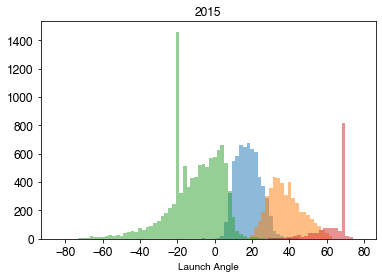

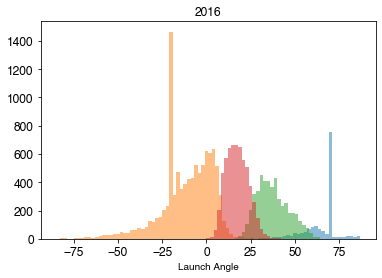

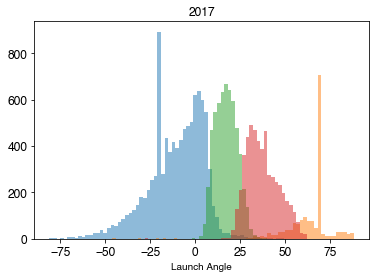

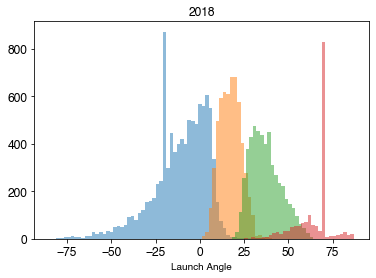

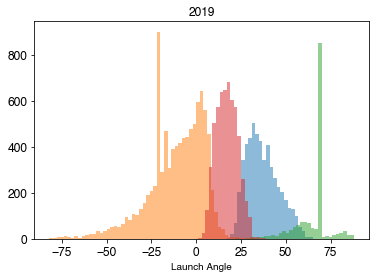

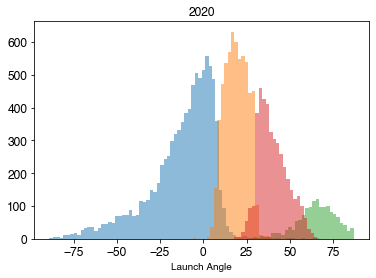

In [5]:
for i,year in enumerate(range(2015, 2021)):
    plot_bb_profile(dfs[i])
    plt.title(f'{year}')
    plt.xlabel("Launch Angle")
    plt.show()

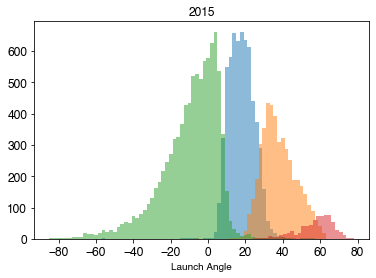

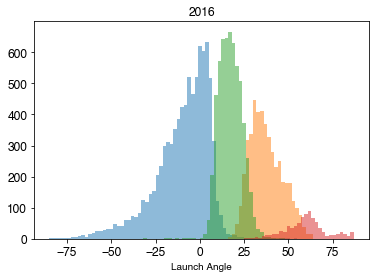

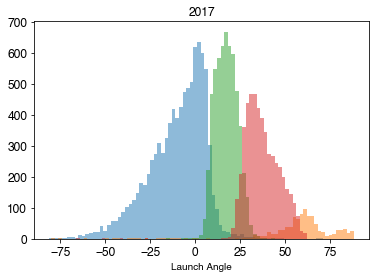

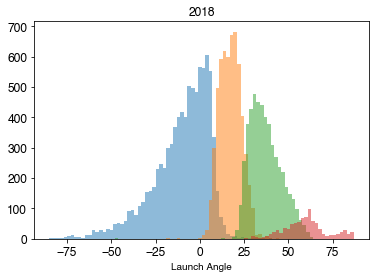

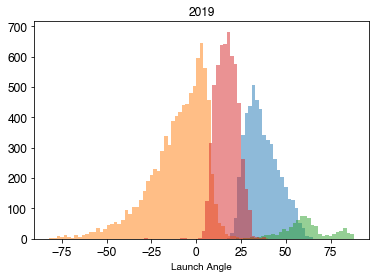

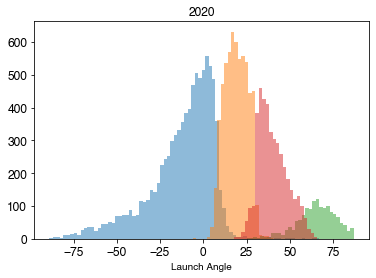

In [6]:
for i,year in enumerate(range(2015, 2021)):
    skimmed_df = dfs[i].merge(summary.drop_duplicates(), how="left", on=["launch_angle","launch_speed","bb_type"],indicator=True)
    plot_bb_profile(skimmed_df[skimmed_df['_merge'] == 'left_only'])
    plt.title(f'{year}')
    plt.xlabel("Launch Angle")
    plt.show()

Output distributions look clean, so this set looks like a good start.

Also want to output top handful for each bb_type for each year. This repeats some code above - not the cleanest, but I don't want the key parts of the notebook buried under a huge number of tables.

In [8]:
for year,df in zip(range(2015, 2021),dfs):
    for bb_type in dfs[0].bb_type.dropna().unique():
        # Isolate each bb_type
        i = df[df["bb_type"] == bb_type]
        # Sort by pairs of launch angle and speed
        i = i.groupby(["launch_angle", "launch_speed"]).size().reset_index(name="count").sort_values("count", ascending=False)
        # Derive fraction of total
        i["fraction"] = i["count"] / i["count"].sum()
        print(f"bb_type: {bb_type}, year: {year}")
        print(i.head(5))

bb_type: line_drive, year: 2015
      launch_angle  launch_speed  count  fraction
2293          18.0          91.1     16  0.002569
1628          15.0          90.4     15  0.002409
2123          17.0          98.8      6  0.000964
2148          17.0         102.1      5  0.000803
1500          14.0         101.8      5  0.000803
bb_type: fly_ball, year: 2015
      launch_angle  launch_speed  count  fraction
2133          39.0          89.2     79  0.017137
1005          31.0          95.6      6  0.001302
1694          36.0          71.4      6  0.001302
887           30.0         102.8      6  0.001302
715           29.0          96.6      4  0.000868
bb_type: ground_ball, year: 2015
      launch_angle  launch_speed  count  fraction
1683         -21.0          82.9   1189  0.113617
2223         -17.0          90.3    186  0.017774
2771         -13.0          90.2     10  0.000956
4583          -3.0          94.0      6  0.000573
4039          -6.0          96.0      5  0.000478
bb_ty

I've copy/pasted the above table and bolded the ones I believe to be "obviously confirmed" from the eyeball-test:

| launch_angle | launch_speed |     bb_type | Years above threshold |
|-------------:|-------------:|------------:|----------------------:|
|        **-21.0** |         **82.9** | **ground_ball** |                     5 |
|        **-17.0** |         **90.3** | **ground_ball** |                     5 |
|         **15.0** |         **90.4** |  **line_drive** |                     2 |
|        **18.0** |         **91.1** |  **line_drive** |                     3 |
|         30.0 |        102.8 |    fly_ball |                     1 |
|         **39.0** |         **89.2** |    **fly_ball** |                     5 |
|         61.0 |         79.9 |       popup |                     1 |
|         62.0 |         86.3 |       popup |                     1 |
|         **69.0** |         **80.0** |       **popup** |                     5 |
|         70.0 |         72.3 |       popup |                     1 |

Not "obviously confirmed" sets:

- 30.0, 102.8 - only shows up in 2015 and 2017. 2015 could go either way, but 2017 seems to be a true outlier.
- 61.0, 79.9 - statistical fluctuation from 2020 (smaller dataset due to COVID cancelled games), not worth dropping
- 62.0, 86.3 - same as above
- 70.0, 72.3 - same as above

**Proposal: removal of the bolded combinations in the table above, as well as 30.0/102.8.**